## Here is walk-through to help getting started with tensorflow

1) Simple Linear Regression with low-level TensorFlow  
2) Simple Linear Regression with a canned estimator  
3) Playing with real data: linear regressor and DNN  
4) Building a custom estimator to classify handwritten digits (MNIST)

### [What's next?](https://goo.gl/hZaLPA)

## Dependencies

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

# tensorflow
import tensorflow as tf
print('Expected TensorFlow version is v1.3.0 or higher')
print('Your TensorFlow version:', tf.__version__)

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12,8]

Expected TensorFlow version is v1.3.0 or higher
Your TensorFlow version: 1.2.1


## 1) Simple Linear Regression with low-level TensorFlow

### Generating data

This function creates a noisy dataset that's roughly linear, according to the equation y = mx + b + noise.

Notice that the expected value for m is 0.1 and for b is 0.3. This is the values we expect the model to predict.

In [19]:
def make_noisy_data(m=0.1, b=0.3, n=100):
    x = np.random.randn(n)
    noise = np.random.normal(scale=0.01, size=len(x))
    y = m * x + b + noise
    return x, y

Create training data

In [22]:
x_train, y_train = make_noisy_data()

Plot the training data

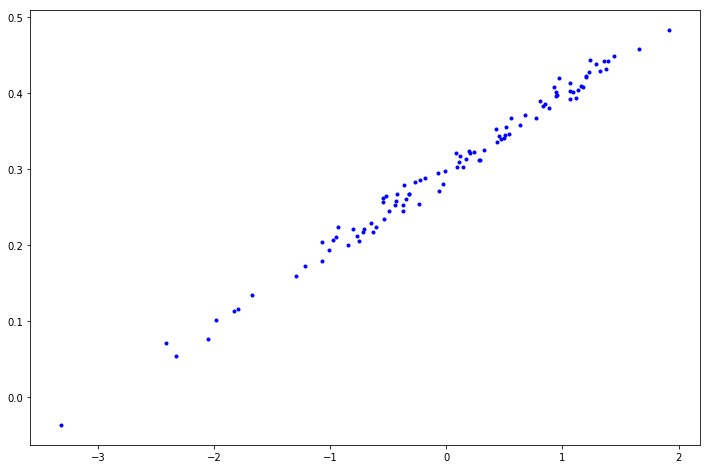

In [23]:
plt.plot(x_train, y_train, 'b.')

### The Model

In [41]:
# input and output
x = tf.placeholder(shape=[None], dtype=tf.float32, name='x')
y_label = tf.placeholder(shape=[None], dtype=tf.float32, name='y_label')

# variables
W = tf.Variable(tf.random_normal([1], name="W")) # weight
b = tf.Variable(tf.random_normal([1], name="b")) # bias

# actual model
y = W * x + b

### The Loss and Optimizer

Define a loss function (here, squared error) and an optimizer (here, gradient descent).

In [42]:
loss = tf.reduce_mean(tf.square(y - y_label))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train = optimizer.minimize(loss)

### The Training Loop and generating predictions

In [43]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init) # initialize variables
  for i in range(100): # train for 100 steps
    sess.run(train, feed_dict={x: x_train, y_label:y_train})

  x_plot = np.linspace(-3, 3, 101) # return evenly spaced numbers over a specified interval
  # using the trained model to predict values for the training data
  preds = sess.run(y, feed_dict={x: fake_data})

  # saving final weight and bias
  final_W = sess.run(W)
  final_b = sess.run(b)

### Visualizing predictions

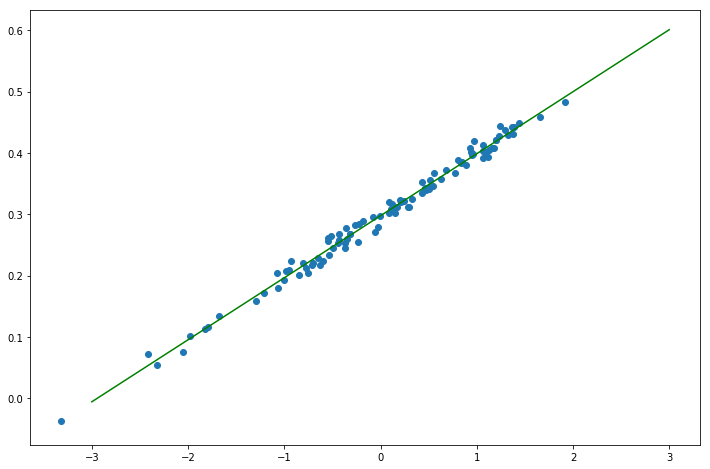

In [44]:
plt.scatter(x_train, y_train)
plt.plot(x_plot, preds, 'g')

### What is the final weight and bias?

In [45]:
print('W:', final_W, 'expected: 0.1')
print('b:', final_b, 'expected: 0.3')

W: [ 0.10109649] expected: 0.1
b: [ 0.29764724] expected: 0.3


## 2) Simple Linear Regression with a canned estimator  

### Input Pipeline

In [46]:
x_dict = {'x': x_train}
train_input = tf.estimator.inputs.numpy_input_fn(x_dict, y_train,
                                                 shuffle=True,
                                                 num_epochs=None) # repeat forever

### Describe input feature usage

In [47]:
features = [tf.feature_column.numeric_column('x')] # because x is a real number

### Build and train the model

In [48]:
estimator = tf.contrib.learn.LinearRegressor(features)
estimator.train(train_input, steps = 1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_tf_random_seed': 1, '_save_checkpoints_secs': 600, '_session_config': None, '_model_dir': '/tmp/tmpwimn62qr', '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpwimn62qr/model.ckpt.
INFO:tensorflow:step = 1, loss = 13.3839
INFO:tensorflow:global_step/sec: 945.012
INFO:tensorflow:step = 101, loss = 0.0116497 (0.107 sec)
INFO:tensorflow:global_step/sec: 1343.43
INFO:tensorflow:step = 201, loss = 0.0102614 (0.074 sec)
INFO:tensorflow:global_step/sec: 1118.81
INFO:tensorflow:step = 301, loss = 0.0129156 (0.089 sec)
INFO:tensorflow:global_step/sec: 1474.31
INFO:tensorflow:step = 401, loss = 0.0139722 (0.068 sec)
INFO:tensorflow:global_step/sec: 1337
INFO:tensorflow:step = 501, loss = 0.0128544 (0.074 sec)
INFO:tensorfl

### Generating and visualizing predictions

In [56]:
x_test_dict = {'x': np.linspace(-5, 5, 11)}
data_source = tf.estimator.inputs.numpy_input_fn(x_test_dict, shuffle=False)

predictions = list(estimator.predict(data_source))
preds = [p['predictions'][0] for p in predictions]

for y in predictions:
    print(y['predictions'])

INFO:tensorflow:Restoring parameters from /tmp/tmpwimn62qr/model.ckpt-1000
[-0.20096385]
[-0.10137823]
[-0.00179261]
[ 0.09779301]
[ 0.19737864]
[ 0.29696426]
[ 0.39654988]
[ 0.4961355]
[ 0.59572113]
[ 0.69530678]
[ 0.79489237]


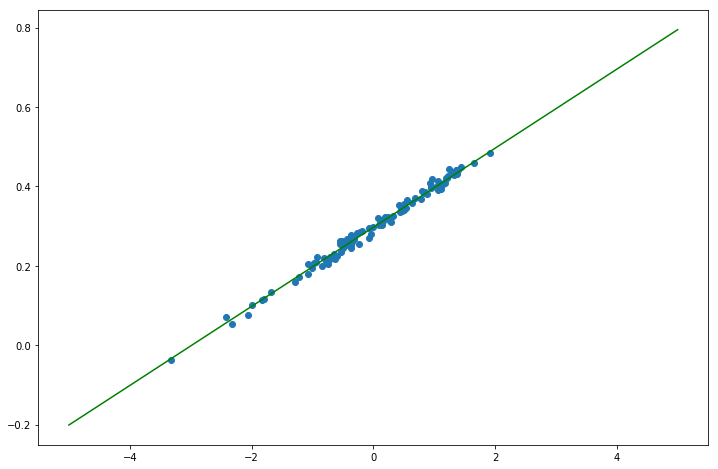

In [57]:
helpplt.scatter(x_train, y_train)
plt.plot(x_test_dict['x'], preds, 'g')

## 3) Playing with real data: linear regressor and DNN  

### Get the data

The Adult dataset is from the Census bureau and the task is to predict whether a given adult makes more than $50,000 a year based attributes such as education, hours of work per week, etc.

But the code here presented can be easilly aplicable to any csv dataset that fits in memory.

More about the data [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/old.adult.names)

In [7]:
census_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
census_train_path = tf.contrib.keras.utils.get_file('census.train', census_train_url)

census_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
census_test_path = tf.contrib.keras.utils.get_file('census.test', census_test_url)

### Load the data

In [8]:
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'sex',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

census_train = pd.read_csv(census_train_path, index_col=False, names=column_names) 
census_test = pd.read_csv(census_train_path, index_col=False, names=column_names) 

census_train_label = census_train.pop('income') == " >50K" 
census_test_label = census_test.pop('income') == " >50K"

In [9]:
census_train.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States


### Input pipeline

In [ ]:
train_input = tf.estimator.inputs.pandas_input_fn(
    census_train, 
    census_train_label,
    shuffle=True, 
    num_epochs=None) # repeat forever

In [ ]:
features, labels = train_input()
features

### Feature description

In [ ]:
features = [
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('hours-per-week'),
    tf.feature_column.bucketized_column(tf.feature_column.numeric_column('age'), list(range(0,100,10))),
    tf.feature_column.categorical_column_with_vocabulary_list('sex', ['male','female']),
    tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000),
]

In [ ]:
estimator = tf.estimator.LinearClassifier(features, n_classes=2, model_dir='census/linear')

In [ ]:
estimator.train(train_input, steps=5000)

### Evaluate the model

In [ ]:
test_input = tf.estimator.inputs.pandas_input_fn(
    census_test, 
    census_test_label, 
    shuffle=True, 
    num_epochs=1)

estimator.evaluate(test_input)

### Examine the results with [TensorBoard](http://0.0.0.0:6006)

In [ ]:
%%bash
tensorboard --logdir census

## DNN model

### Update input pre-processing

In [134]:
features = [
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('hours-per-week'),
    tf.feature_column.bucketized_column(tf.feature_column.numeric_column('age'), list(range(0,100,10))),
    tf.feature_column.categorical_column_with_vocabulary_list('sex',['male','female']),
    tf.feature_column.embedding_column(  # now using embedding!
        tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000), 0)
]

ValueError: Invalid dimension 0.

In [135]:
estimator = tf.estimator.DNNClassifier(features, n_classes=2, model_dir='census/linear')

AttributeError: 'module' object has no attribute 'DNNClassifier'

## Linear Regression - Custom Input Pipeline using Datasets API

### Get the data

In [ ]:
imports85_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
imports85_path = tf.contrib.keras.utils.get_file('imports85.data', imports85_url)

### Read the data

In [ ]:
def imports_85():
    def remove_question_marks(line):
        return tf.py_func(lambda x: "?" not in x, [line], tf.bool)
    
    dataset = (
        tf.contrib.data.TextLineDataset(imports85_path)
            .filter(remove_question_marks)
            .map(csv_decoder)
            .shuffle(buffer_size=100)
            .batch(32)
            .repeat())
    
    columns = dataset.make_one_shot_iterator().get_next()
    
    price = columns.pop('price')
    
    return columns, price/1000

In [ ]:
csv_defaults = collections.OrderedDict([
    ('symboling', [0]),
    ('normalized-losses', [0.]),
    ('make', [""]),
    ('fuel-type', [""]),
    ('aspiration', [""]),
    ('num-of-doors', [""]),
    ('body-style', [""]),
    ('drive-wheels', [""]),
    ('engine-location', [""]),
    ('wheel-base', [0.]),
    ('length', [0.]),
    ('width', [0.]),
    ('height', [0.]),
    ('curb-weight', [0.]),
    ('engine-type', [""]),
    ('num-of-cylynders', [""]),
    ('engine-size', [0.]),
    ('fuel-system', [""]),
    ('bore', [0.]),
    ('stroke', [0.]),
    ('compression-ratio', [0.]), 
    ('horsepower', [0.]),
    ('peak-rpm', [0.]),
    ('city-mpg', [0.]),
    ('highway-mpg', [0.]),
    ('price', [0.])])

In [ ]:
def csv_decoder(line):
  parsed = tf.decode_csv(line, csv_defaults.values())

  return dict(zip(csv_defaults.keys(), parsed))
  

### Try the input function

In [ ]:
tf.reset_default_graph()
training_batch = imports_85()

In [ ]:
with tf.Session() as sess:
    features, price = sess.run(training_batch)

In [ ]:
print(features['highway-mpg'])

In [ ]:
print(features['body-style'])

In [ ]:
print(price)

### Input Processing

In [ ]:
features = [
    tf.feature_column.numeric_column('curb-weight'),
    tf.feature_column.numeric_column('highway-mpg'),
    tf.feature_column.categorical_column_with_vocabulary_list(
        'body-style', ['sedan', 'hatchback', 'wagon','hardtop','convertible']),
    tf.feature_column.categorical_column_with_hash_bucket('make', 256)
]

### Build the model

In [ ]:
estimator = tf.estimator.LinearRegressor(features)
estimator.train(imports_85, steps = 10000)

In [ ]:
2.8236e+08**0.5

## 4) Building a custom estimator to classify handwritten digits (MNIST)

![mnist](http://rodrigob.github.io/are_we_there_yet/build/images/mnist.png?1363085077)
Image from: http://rodrigob.github.io/are_we_there_yet/build/images/mnist.png?1363085077

In [10]:
# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# MNIST
from tensorflow.examples.tutorials.mnist import input_data

# Enable TensorFlow logs
tf.logging.set_verbosity(tf.logging.INFO)

In [11]:
# Parameters
BATCH_SIZE = 128
STEPS = 10000

### Input functions using datasets and numpy just for learning purposes

In [12]:
def dataset_input_fn(features, labels, num_epochs=100, buffer_size=10000):
  def input_fn():
    # creating dataset
    dataset = (tf.contrib.data.Dataset.from_tensor_slices((features, labels))
               .shuffle(buffer_size=buffer_size)
               .repeat(num_epochs)
               .batch(BATCH_SIZE))
    # creating iterator
    feature, label = dataset.make_one_shot_iterator().get_next()
    feature_dict = {
        'x': feature
    }
    return feature_dict, label
  return input_fn

# Import the MNIST dataset
mnist = input_data.read_data_sets('/tmp/MNIST/', one_hot=True)

x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

# Input functions
train_input_fn = dataset_input_fn(x_train, y_train)

x_test_dict = {'x': x_test}
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x_test_dict, y_test, batch_size=BATCH_SIZE,
    shuffle=False, num_epochs=1)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST/t10k-labels-idx1-ubyte.gz


## Model function

In [13]:

def model_fn(features, labels, mode):
  # Describing the model
  input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])

  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32, kernel_size=[5, 5],
                           padding='same', activation=tf.nn.relu)
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  conv2 = tf.layers.conv2d(inputs=input_layer,filters=64, kernel_size=[5, 5],
                           padding='same', activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  is_training_mode = mode == tf.estimator.ModeKeys.TRAIN
  dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training_mode)

  logits = tf.layers.dense(inputs=dropout, units=10)

  # Generate Predictions
  classes = tf.argmax(input=logits, axis=1)
  predictions = {
      'classes': classes,
      'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    # Return an EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  loss = tf.losses.softmax_cross_entropy(onehot_labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=1e-4,
        optimizer='Adam')

    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                      loss=loss, train_op=train_op)

  # Configure the accuracy metric for evaluation
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          tf.argmax(input=logits, axis=1),
          tf.argmax(input=labels, axis=1))
  }

  return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                    loss=loss, eval_metric_ops=eval_metric_ops)


## Runs estimator

In [ ]:
# create estimator
run_config = tf.contrib.learn.RunConfig(model_dir='/tmp/pros')
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)

# train for 10000 steps
estimator.train(input_fn=train_input_fn, steps=STEPS)

# evaluate
estimator.evaluate(input_fn=test_input_fn)

# predict
preds = estimator.predict(input_fn=test_input_fn)

INFO:tensorflow:Using config: {'_num_worker_replicas': 0, '_session_config': None, '_num_ps_replicas': 0, '_master': '', '_keep_checkpoint_max': 5, '_is_chief': True, '_save_checkpoints_steps': None, '_model_dir': '/tmp/pros', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6c7c9b9470>, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_tf_random_seed': None, '_task_type': None, '_evaluation_master': '', '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_environment': 'local'}
INFO:tensorflow:Create CheckpointSaverHook.


## Distributed tensorflow: using experiments

In [ ]:
# create experiment
def experiment_fn(run_config, hparams):
  # create estimator
  estimator = tf.estimator.Estimator(model_fn=model_fn,
                                     config=run_config)
  return tf.contrib.learn.Experiment(
      estimator,
      train_input_fn=train_input_fn,
      eval_input_fn=test_input_fn,
      train_steps=STEPS
  )

# run experiment
learn_runner.run(experiment_fn,
    run_config=run_config)